Ben Ghertner 2025

Code to generate the inversion background + extensions from appendix B and generate the linear wave mode with near interface corrections to $\theta_\ell$.

    - Figure B.1
    - Figure 3.3
    - Figure 3.8

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sys

sys.path.append('../misc_routines/')
from partial_derivs import get_partial_derivatives

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.usetex'] = True
plt.rcParams["font.size"] = 11

%matplotlib inline

In [2]:
#Constants
Rd = 287.04
Rv = 461.5
cpd = 1005.7
cpv = 1870
cpl = 4190.0
g = 9.81

p0 = 1e5

#Helpful functions

#Kirchoff's approximation for the latent heat of vapourization
lv = lambda T: 2.501e6 + (cpl - cpv)*(T - 273.15)

# r^* function as in CM1
def rslf(p,T):
    estar = 611.2 * np.exp( 17.67 * ( T  - 273.15 ) / ( T  - 29.65 ) )
    return Rd/Rv*estar/(p-estar)

#theta_l as a function of p,T,rT as in Eq. (B.15)
def thl_func(p,T,rT):
    rs = rslf(p, T)
    rl = np.maximum(0., rT-rs)
    rv = rT - rl
    RT  = Rd + rT*Rv
    cpT = cpd + rT*cpv
    lambc = lv(T)/cpT/T

    return T*(p0/p)**(RT/cpT)*np.exp(-lambc*rl)*((Rd+rv*Rv)/RT)**(RT/cpT)*(rT/rv)**(rT*Rv/cpT)

#dewpoint partial derivative for numerical root finding as in Eq. (B.17)
def dlT_dlthl(p,T):
        rs   = rslf(p, T)
        RT  = Rd + rs*Rv
        cpT = cpd + rs*cpv
        lambR = lv(T)/Rv/T
        lambc = lv(T)/cpT/T
        lamb  = lambc*lambR*RT/Rd*rs

        return 1/(1+lamb)

In [3]:
#Set background constants

ps = 8.362e4
Ts = 279.8
rs = rslf(ps,Ts)
theta_s = Ts*(p0/ps)**(Rd/cpd)*((Rd+rs*Rv)/Rd/(1+rs))

N2t_0 = 0.5e-4
N2i_0 = 3.9e-4

HT = 1500
Hi = 600
Hc = 300

alpha = 1.0e-4
RHinf = 0.75
gam   = 0.004

#These come from CM1 init3d_BLG.F inversionwave
N2t = 4.19864664E-05
N2i = 3.66779772E-04
N2c = 2.03111340E-04

**Generate backbground state with top and bottom extensions (Appendix B)**

In [4]:
#Note grid needs to be choosen so that Hc and Hi are grid points
dz = 1.0
zz = np.arange(0., HT+dz, dz)

#############################################
#                                           #
#       Stage 1: Dewpoint Background        #
#                                           #
#############################################

#Eq. (B.2)
theta_r_B = theta_s*np.exp(N2i_0/g*zz)
theta_r_T = theta_s*np.exp(N2t_0/g*zz + (N2i_0-N2t_0)/g*Hi)

#Eq. (B.4)
pi_B = (ps/p0)**(Rd/cpd) - g**2/cpd/theta_s*(1/N2i_0)*(1 - np.exp(-N2i_0/g*zz))
pi_T = (ps/p0)**(Rd/cpd) - g**2/cpd/theta_s*( (1/N2i_0) + ((1/N2t_0) - (1/N2i_0))*np.exp(-N2i_0/g*Hi) \
                                             -(1/N2t_0)*np.exp((N2t_0-N2i_0)/g*Hi - N2t_0/g*zz) )

p_B = p0*pi_B**(cpd/Rd)
p_T = p0*pi_T**(cpd/Rd)

#######################################
###  Nonlinear Solve for T* and r*  ###
#######################################

#Bottom + extension
T_B = theta_r_B*pi_B
for idz in range(zz.size):
    Tlast  = 0.0
    while np.abs((Tlast-T_B[idz])/T_B[idz]) > 1e-6:
        Tlast = T_B[idz]
        #Eq. (B.5)
        T_B[idz] = theta_r_B[idz]*pi_B[idz]*Rd*(1 + rslf(p_B[idz], T_B[idz]))/(Rd + Rv*rslf(p_B[idz], T_B[idz]))

#Top + extension
T_T = theta_r_T*pi_T
for idz in range(zz.size):
    Tlast  = 0.0
    while np.abs((Tlast-T_T[idz])/T_T[idz]) > 1e-6:
        Tlast = T_T[idz]
        #Eq. (B.5)
        T_T[idz] = theta_r_T[idz]*pi_T[idz]*Rd*(1 + rslf(p_T[idz], T_T[idz]))/(Rd + Rv*rslf(p_T[idz], T_T[idz]))

#Compute thl*
thl_B = T_B*(p0/p_B)**((Rd+rslf(p_B, T_B)*Rv)/(cpd+rslf(p_B, T_B)*cpv))
thl_T = T_T*(p0/p_T)**((Rd+rslf(p_T, T_T)*Rv)/(cpd+rslf(p_T, T_T)*cpv))

#Compute r*
rs_B = rslf(p_B, T_B)
rs_T = rslf(p_T, T_T)

#############################################
#                                           #
#     Stage 2: Cloud Water Perturbation     #
#                                           #
#############################################

idHc = np.argwhere(zz == Hc)[0,0]
idHi = np.argwhere(zz == Hi)[0,0]

#Humidity function Eq. (B.11)
H = (rs_T[idHc]*RHinf*(1 + np.tanh(gam*(Hc-Hi))) - rs_B[idHc]*(1 + alpha*Hc + (1 - alpha*Hc)*np.tanh(gam*(Hc-Hi))))/(-alpha*rs_B[idHc]*(1 - np.tanh(gam*(Hc-Hi))))

#Eq. (B.9)
rT_B = rslf(p_B, T_B)*(1 - alpha*(zz - H))
rT_T = rslf(p_T, T_T)*RHinf

#Eq. (B.10)
rT = 1/2*((rT_B + rT_T) - (rT_B - rT_T)*np.tanh(gam*(zz - Hi)))

idT = np.argwhere(zz >= Hi)
idB = np.argwhere(zz <= Hi)

#######################################
###       Pressure Correction       ###
#######################################

#initialize arrays
p = np.empty_like(p_T)
pi = np.empty_like(pi_T)
T = np.empty_like(T_T)
thl = np.empty_like(thl_T)
thr = np.empty_like(theta_r_T)

#Set cloud edge values to integrate from
p[idHc] = p_B[idHc]
pi[idHc] = pi_B[idHc]
T[idHc] = T_B[idHc]
thl[idHc] = thl_B[idHc]
thr[idHc] = theta_r_B[idHc]

#Integrate up from cloud edge
for i in np.arange(idHc+1, zz.size, 1):
    #first guess values are star values
    if zz[i] < Hi: T[i], p[i], thl[i] = T_B[i], p_B[i], thl_B[i]
    else:          T[i], p[i], thl[i] = T_T[i], p_T[i], thl_T[i]

    Tlast = 0.0
    while(np.abs((Tlast-T[i])/T[i]) > 1e-7):
        Tlast  = T[i]

        #Compute thr directly Eq. (B.13)
        T[i]   = thl[i]*(p[i]/p0)**((Rd+rT[i]*Rv)/(cpd+rT[i]*cpv))
        thr[i] = T[i]*(p0/p[i])**(Rd/cpd)*(Rd+rT[i]*Rv)/Rd/(1+rT[i])

        #Numerical pressure step Eq. (B.12)
        pi[i]  = pi[i-1]-g*dz/(cpd*0.5*(thr[i]+thr[i-1]))        
        p[i]   = p0*(pi[i]**(cpd/Rd))


#Integrating down into cloud
for i in np.arange(idHc-1, -1, -1):
    #first guess values are star values
    T[i], p[i], thl[i] = T_B[i], p_B[i], thl_B[i]

    Tlast = 0.0

    #Use linearized formula for a first guess at T
    lambc = lv(T[i])/(cpd+rT[i]*cpv)/T[i]
    rl = (rT[i] - rs_B[i])*dlT_dlthl(p[i],T[i])
    rv = rT[i] - rl
    T[i] = T[i]*(1 + lambc*rl)

    #Nonlinear solve for pressure
    #Use Newton step to get T at each iteration
    while(np.abs((Tlast-T[i])/T[i]) > 1e-7):
        Tlast = T[i]

        #Newton step Eq. (B.17)
        T[i] = T[i]*(1 - np.log(thl_func(p[i],T[i],rT[i])/thl[i])*dlT_dlthl(p[i],T[i]) )

        rv = rslf(p[i],T[i])
        rl = rT[i] - rv
        thr[i] = T[i]*(p0/p[i])**(Rd/cpd)*(Rd+rv*Rv)/Rd/(1.0+rT[i])

        #Numerical pressure step Eq. (B.12)
        pi[i] = pi[i+1]+g*dz/(cpd*0.5*(thr[i]+thr[i+1]))
        p[i]=p0*(pi[i]**(cpd/Rd))
        

Figure B.1

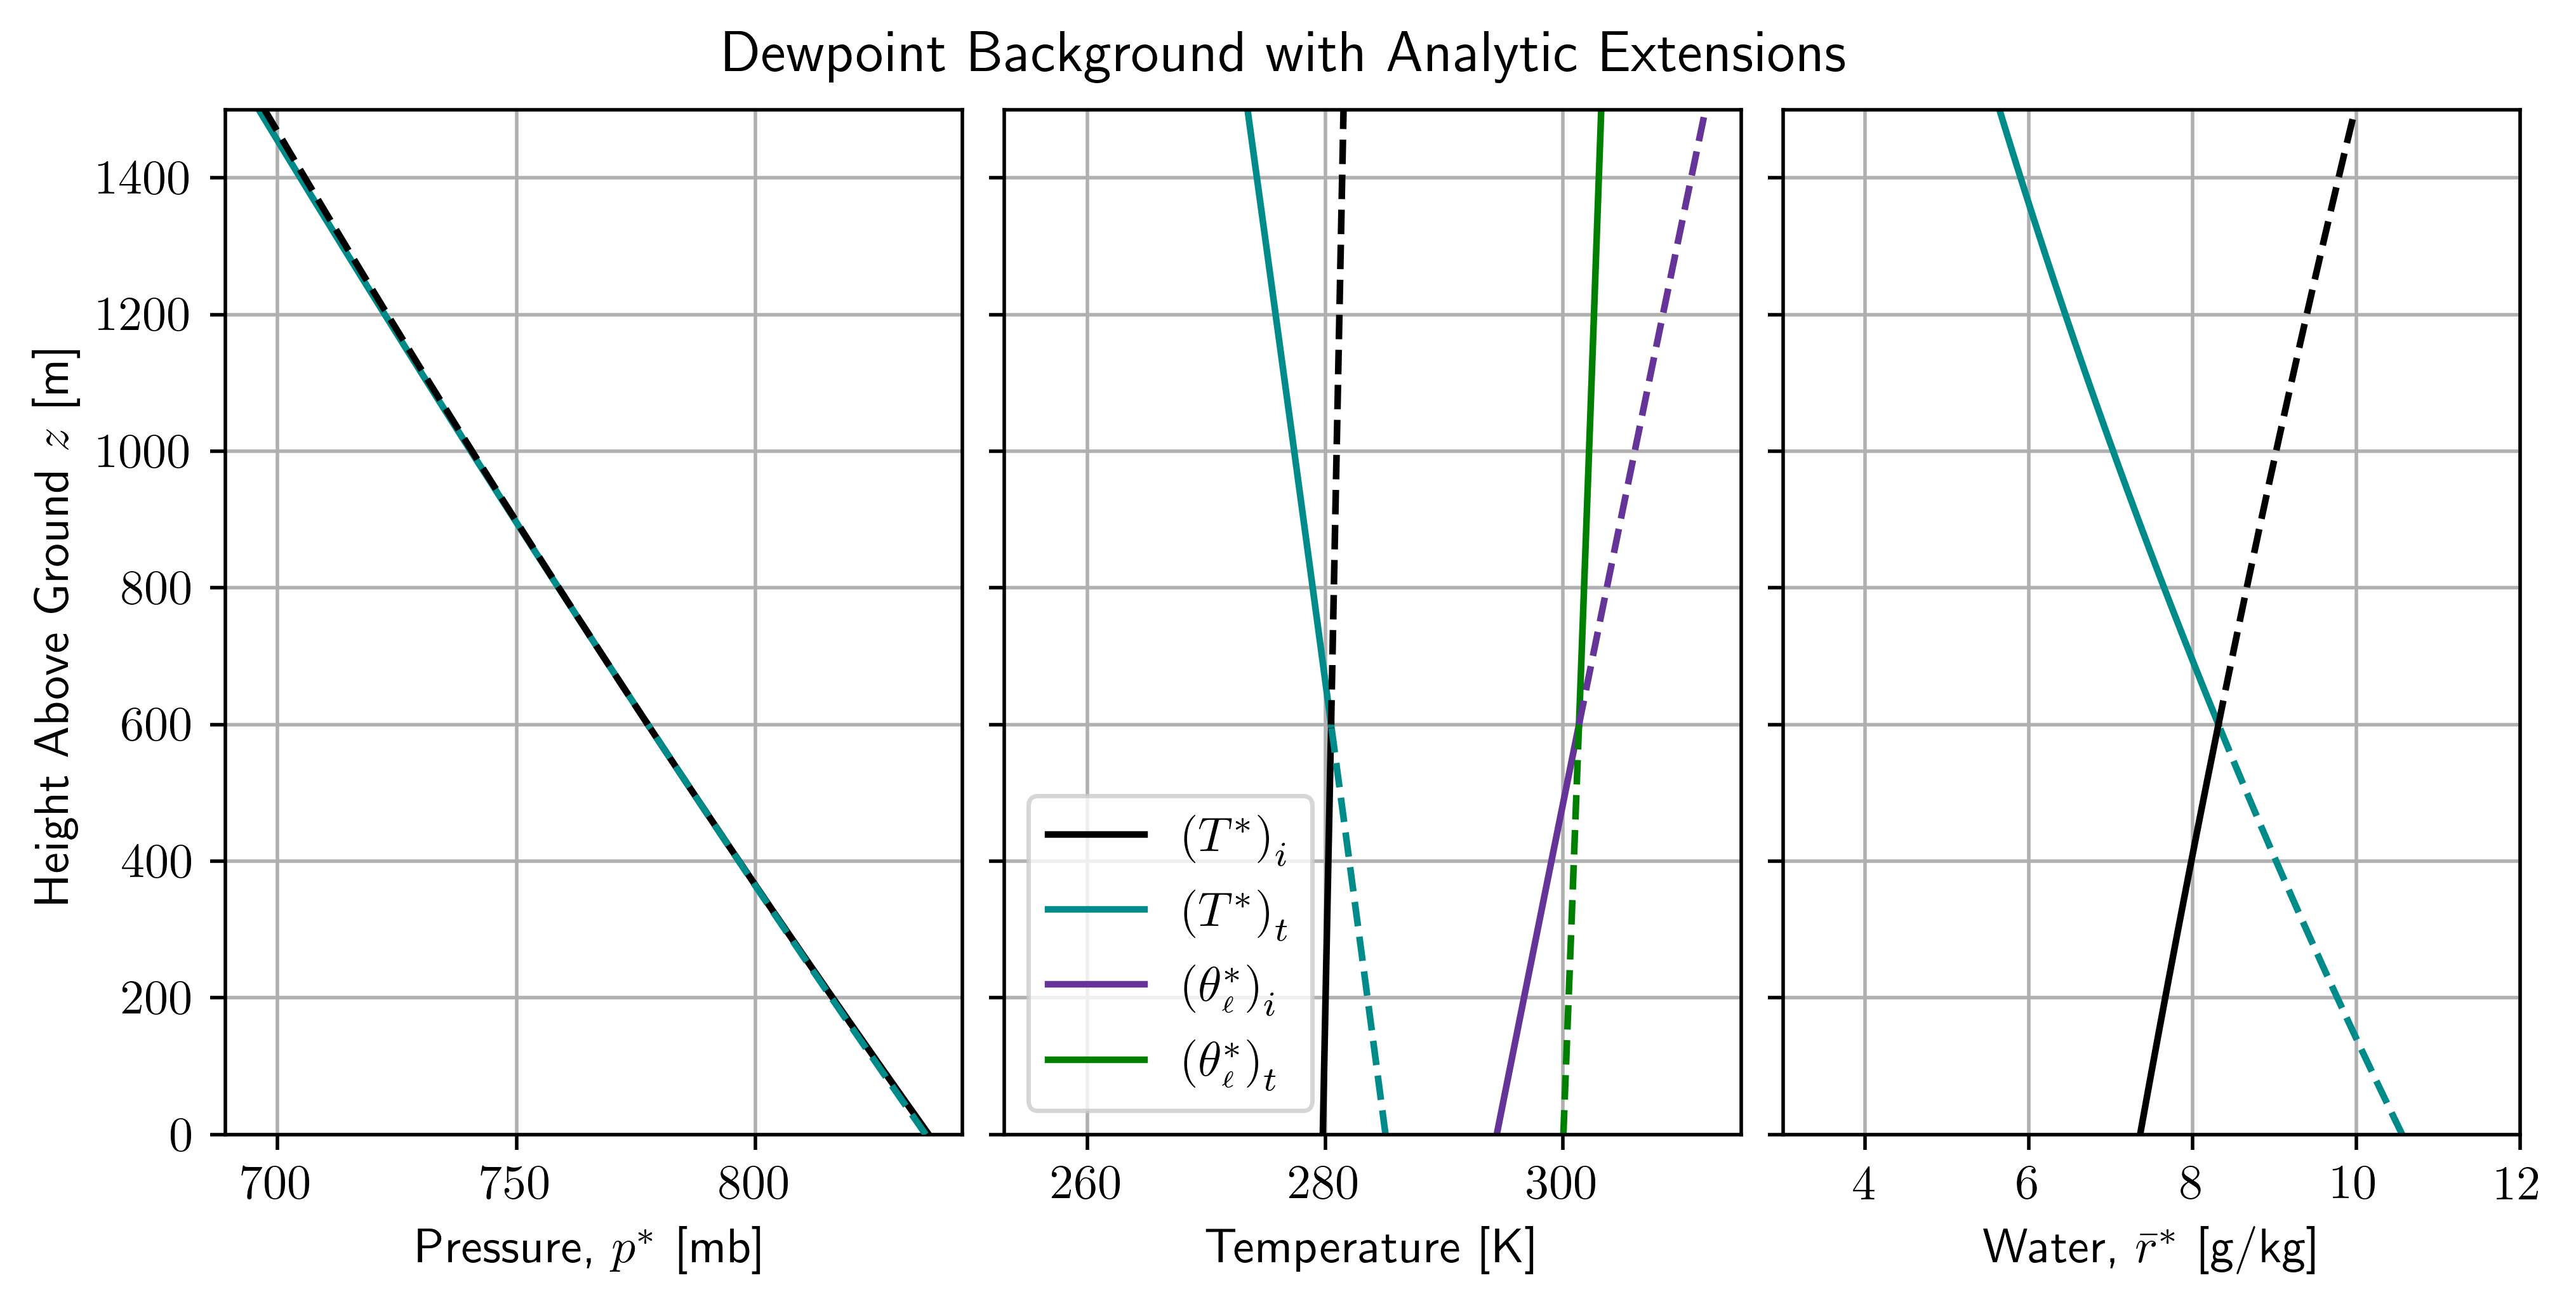

In [5]:
fig, axes = plt.subplots(ncols=3, sharey=True, layout='constrained')
fig.set_dpi(500)
fig.set_size_inches(8,4)

fig.suptitle('Dewpoint Background with Analytic Extensions')

axes[0].grid()
axes[0].set_ylim(0,zz[-1])
axes[0].plot(p_T[idT]/100, zz[idT], color='darkcyan')
axes[0].plot(p_B[idB]/100, zz[idB], color='k')
axes[0].plot(p_T[idB]/100, zz[idB], '--', color='darkcyan', zorder=5)
axes[0].plot(p_B[idT]/100, zz[idT], '--', color='k')
axes[0].set(ylabel=r'Height Above Ground $z$ [m]', xlabel=r'Pressure, $p^*$ [mb]')

axes[1].grid()
axes[1].set_ylim(0,zz[-1])
axes[1].set_xlim(253,315)
axes[1].plot(T_B[idB], zz[idB], color='k', label=r'$\left(T^*\right)_i$')
axes[1].plot(T_T[idT], zz[idT], color='darkcyan', label=r'$\left(T^*\right)_t$')
axes[1].plot(T_T[idB], zz[idB], '--', color='darkcyan')
axes[1].plot(T_B[idT], zz[idT], '--', color='k')
axes[1].plot(thl_B[idB], zz[idB], color='rebeccapurple', 
             label=r'$\left(\theta_{\scriptscriptstyle \ell}^*\right)_i$')
axes[1].plot(thl_T[idT], zz[idT], 'g', 
             label=r'$\left(\theta_{\scriptscriptstyle \ell}^*\right)_t$')
axes[1].plot(thl_T[idB], zz[idB], '--', color='g')
axes[1].plot(thl_B[idT], zz[idT], '--', color='rebeccapurple')
axes[1].set(xlabel=r'Temperature [K]')
axes[1].legend(loc='lower left')

axes[2].grid()
axes[2].plot(rs_T[idT]*1000, zz[idT], 'darkcyan')
axes[2].plot(rs_T[idB]*1000, zz[idB], '--', color='darkcyan')
axes[2].plot(rs_B[idT]*1000, zz[idT], '--', color='k')
axes[2].plot(rs_B[idB]*1000, zz[idB], 'k')
axes[2].set(xlabel=r'Water, $\bar{r}^*$ [g/kg]')
axes[2].set(xlim=(3,12))

plt.show()

In [6]:
#compute N2 in each region

#Partial derivatives
Ju, Js, symbols = get_partial_derivatives()

#Extract for conviences
dlTr_dlthl_u = Ju[0,1]
dlTr_dlrT_u  = Ju[0,2]

dlTr_dlthl_s = Js[0,1]
dlTr_dlrT_s  = Js[0,2]

#Finite Difference to get the gradients of thl and rT
dlogthl_T = np.log(thl_T[2:]/thl_T[:-2])/(2*dz)
dlogthl_B = np.log(thl_B[2:]/thl_B[:-2])/(2*dz)
dlogrT  = np.log(rT[2:]/rT[:-2])/(2*dz)

#Grid Points in each region
zT = zz[idHi:-1]
zi = zz[idHc:idHi+1]
zc = zz[1:idHc+1]

#Initialize arrays of N^2 values
N2t_array = np.empty_like(zT)
N2i_array = np.empty_like(zi)
N2c_array = np.empty_like(zc)

#Computed N^2 in each region and store in array
for i in np.arange(idHi, zz.size-1, 1):
    param_dict = {
        symbols[0]: T[i],
        symbols[1]: np.maximum(rT[i] - rslf(p[i], T[i]), 0.0),
        symbols[2]: p[i],
        symbols[3]: rT[i]
    }
    N2t_array[i-idHi] = (dlogthl_T[i-1]*dlTr_dlthl_u.subs(param_dict) + dlogrT[i-1]*dlTr_dlrT_u.subs(param_dict))*g

for i in np.arange(idHc, idHi+1, 1):
    param_dict = {
        symbols[0]: T[i],
        symbols[1]: np.maximum(rT[i] - rslf(p[i], T[i]), 0.0),
        symbols[2]: p[i],
        symbols[3]: rT[i]
    }
    N2i_array[i-idHc] = (dlogthl_B[i-1]*dlTr_dlthl_u.subs(param_dict) + dlogrT[i-1]*dlTr_dlrT_u.subs(param_dict))*g

for i in np.arange(1, idHc+1, 1):
    param_dict = {
        symbols[0]: T[i],
        symbols[1]: np.maximum(rT[i] - rslf(p[i], T[i]), 0.0),
        symbols[2]: p[i],
        symbols[3]: rT[i]
    }
    N2c_array[i-1] = (dlogthl_B[i-1]*dlTr_dlthl_s.subs(param_dict) + dlogrT[i-1]*dlTr_dlrT_s.subs(param_dict))*g


Figure 3.3

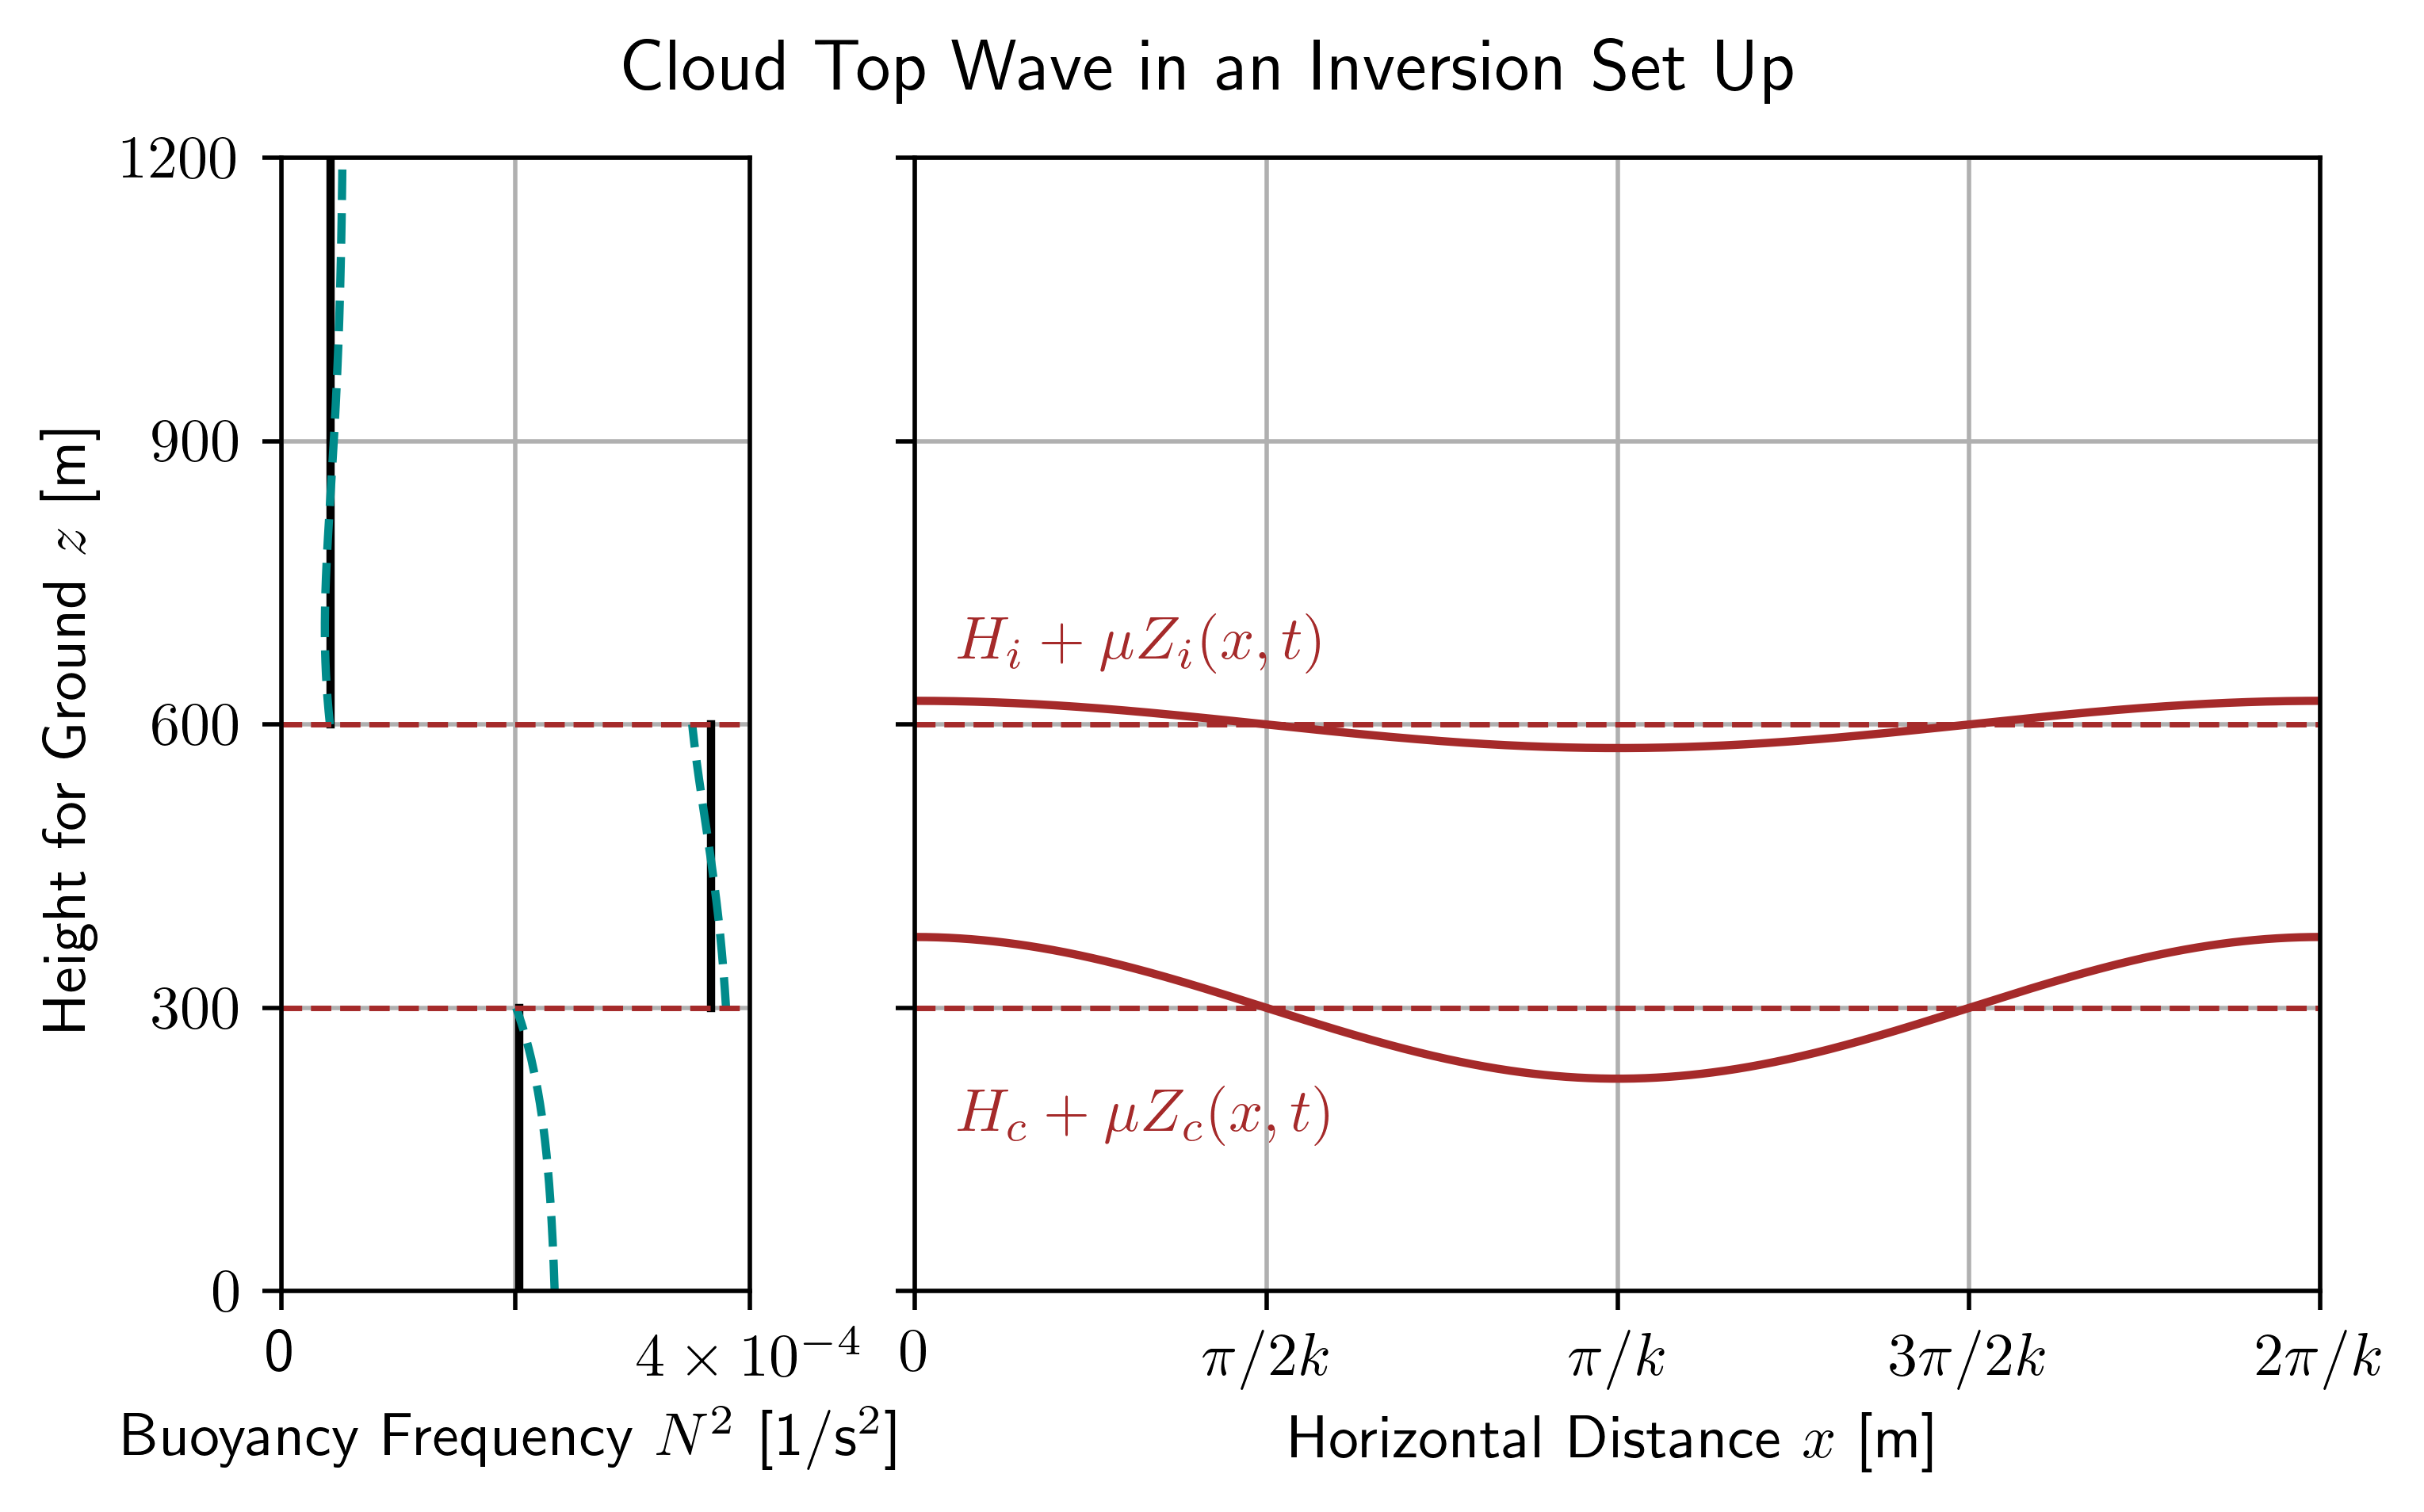

In [7]:
fig, axes = plt.subplot_mosaic([['N2', 'ints']], sharey=True, layout='constrained', width_ratios=[.25,0.75])
fig.set_size_inches(6,3.7)
fig.set_dpi(500)

axes['N2'].plot(N2t*np.ones_like(zT), zT, 'k')
axes['N2'].plot(N2i*np.ones_like(zi), zi, 'k')
axes['N2'].plot(N2c*np.ones_like(zc), zc, 'k')

axes['N2'].plot(N2t_array, zT, 'darkcyan', linestyle='--')
axes['N2'].plot(N2i_array, zi, 'darkcyan', linestyle='--')
axes['N2'].plot(N2c_array, zc, 'darkcyan', linestyle='--')

axes['N2'].grid()
axes['N2'].set(ylim=(0,1200), xlim=(0,4e-4))
axes['N2'].set(ylabel=r'Height for Ground $z$ [m]', xlabel=r'Buoyancy Frequency $N^2$ [1/s$^2$]')

axes['N2'].set_xticks([0., 2e-4, 4e-4])
axes['N2'].set_xticklabels(['0', '', r'$4\times10^{-4}$'])

axes['N2'].axhline(300, color='brown', linestyle='dashed', linewidth=1)
axes['N2'].axhline(600, color='brown', linestyle='dashed', linewidth=1)

axes['N2'].set_yticks([0, 300, 600, 900, 1200])

axes['ints'].axhline(300, color='brown', linestyle='dashed', linewidth=1)
axes['ints'].axhline(600, color='brown', linestyle='dashed', linewidth=1)

axes['ints'].set_xticks([0, 0.25, 0.5, 0.75, 1])
axes['ints'].set_xticklabels([r'$0$', r'$\pi/2k$', r'$\pi/k$', r'$3\pi/2k$', r'$2\pi/k$'])

axes['ints'].grid()

xx = np.linspace(0,1,1000)
axes['ints'].set(xlim=(0,1))
axes['ints'].plot(xx, 600+25*np.cos(xx*2*np.pi), color='brown', label=r'$H_i + \mu Z_i(x,t)$')
axes['ints'].plot(xx, 300+75*np.cos(xx*2*np.pi), color='brown', label=r'$H_c + \mu Z_c(x,t)$')
axes['ints'].annotate(r'$H_i + \mu Z_i(x,t)$', (0.03, 670), color='brown')
axes['ints'].annotate(r'$H_c + \mu Z_c(x,t)$', (0.03, 170), color='brown')

axes['ints'].set(xlabel=r'Horizontal Distance $x$ [m]')

fig.suptitle('Cloud Top Wave in an Inversion Set Up ')

plt.show()

Figure 3.8

lambda1 = 4.3e-18 (This needs to be 0 (numerically) or you have the wrong eigenvector)


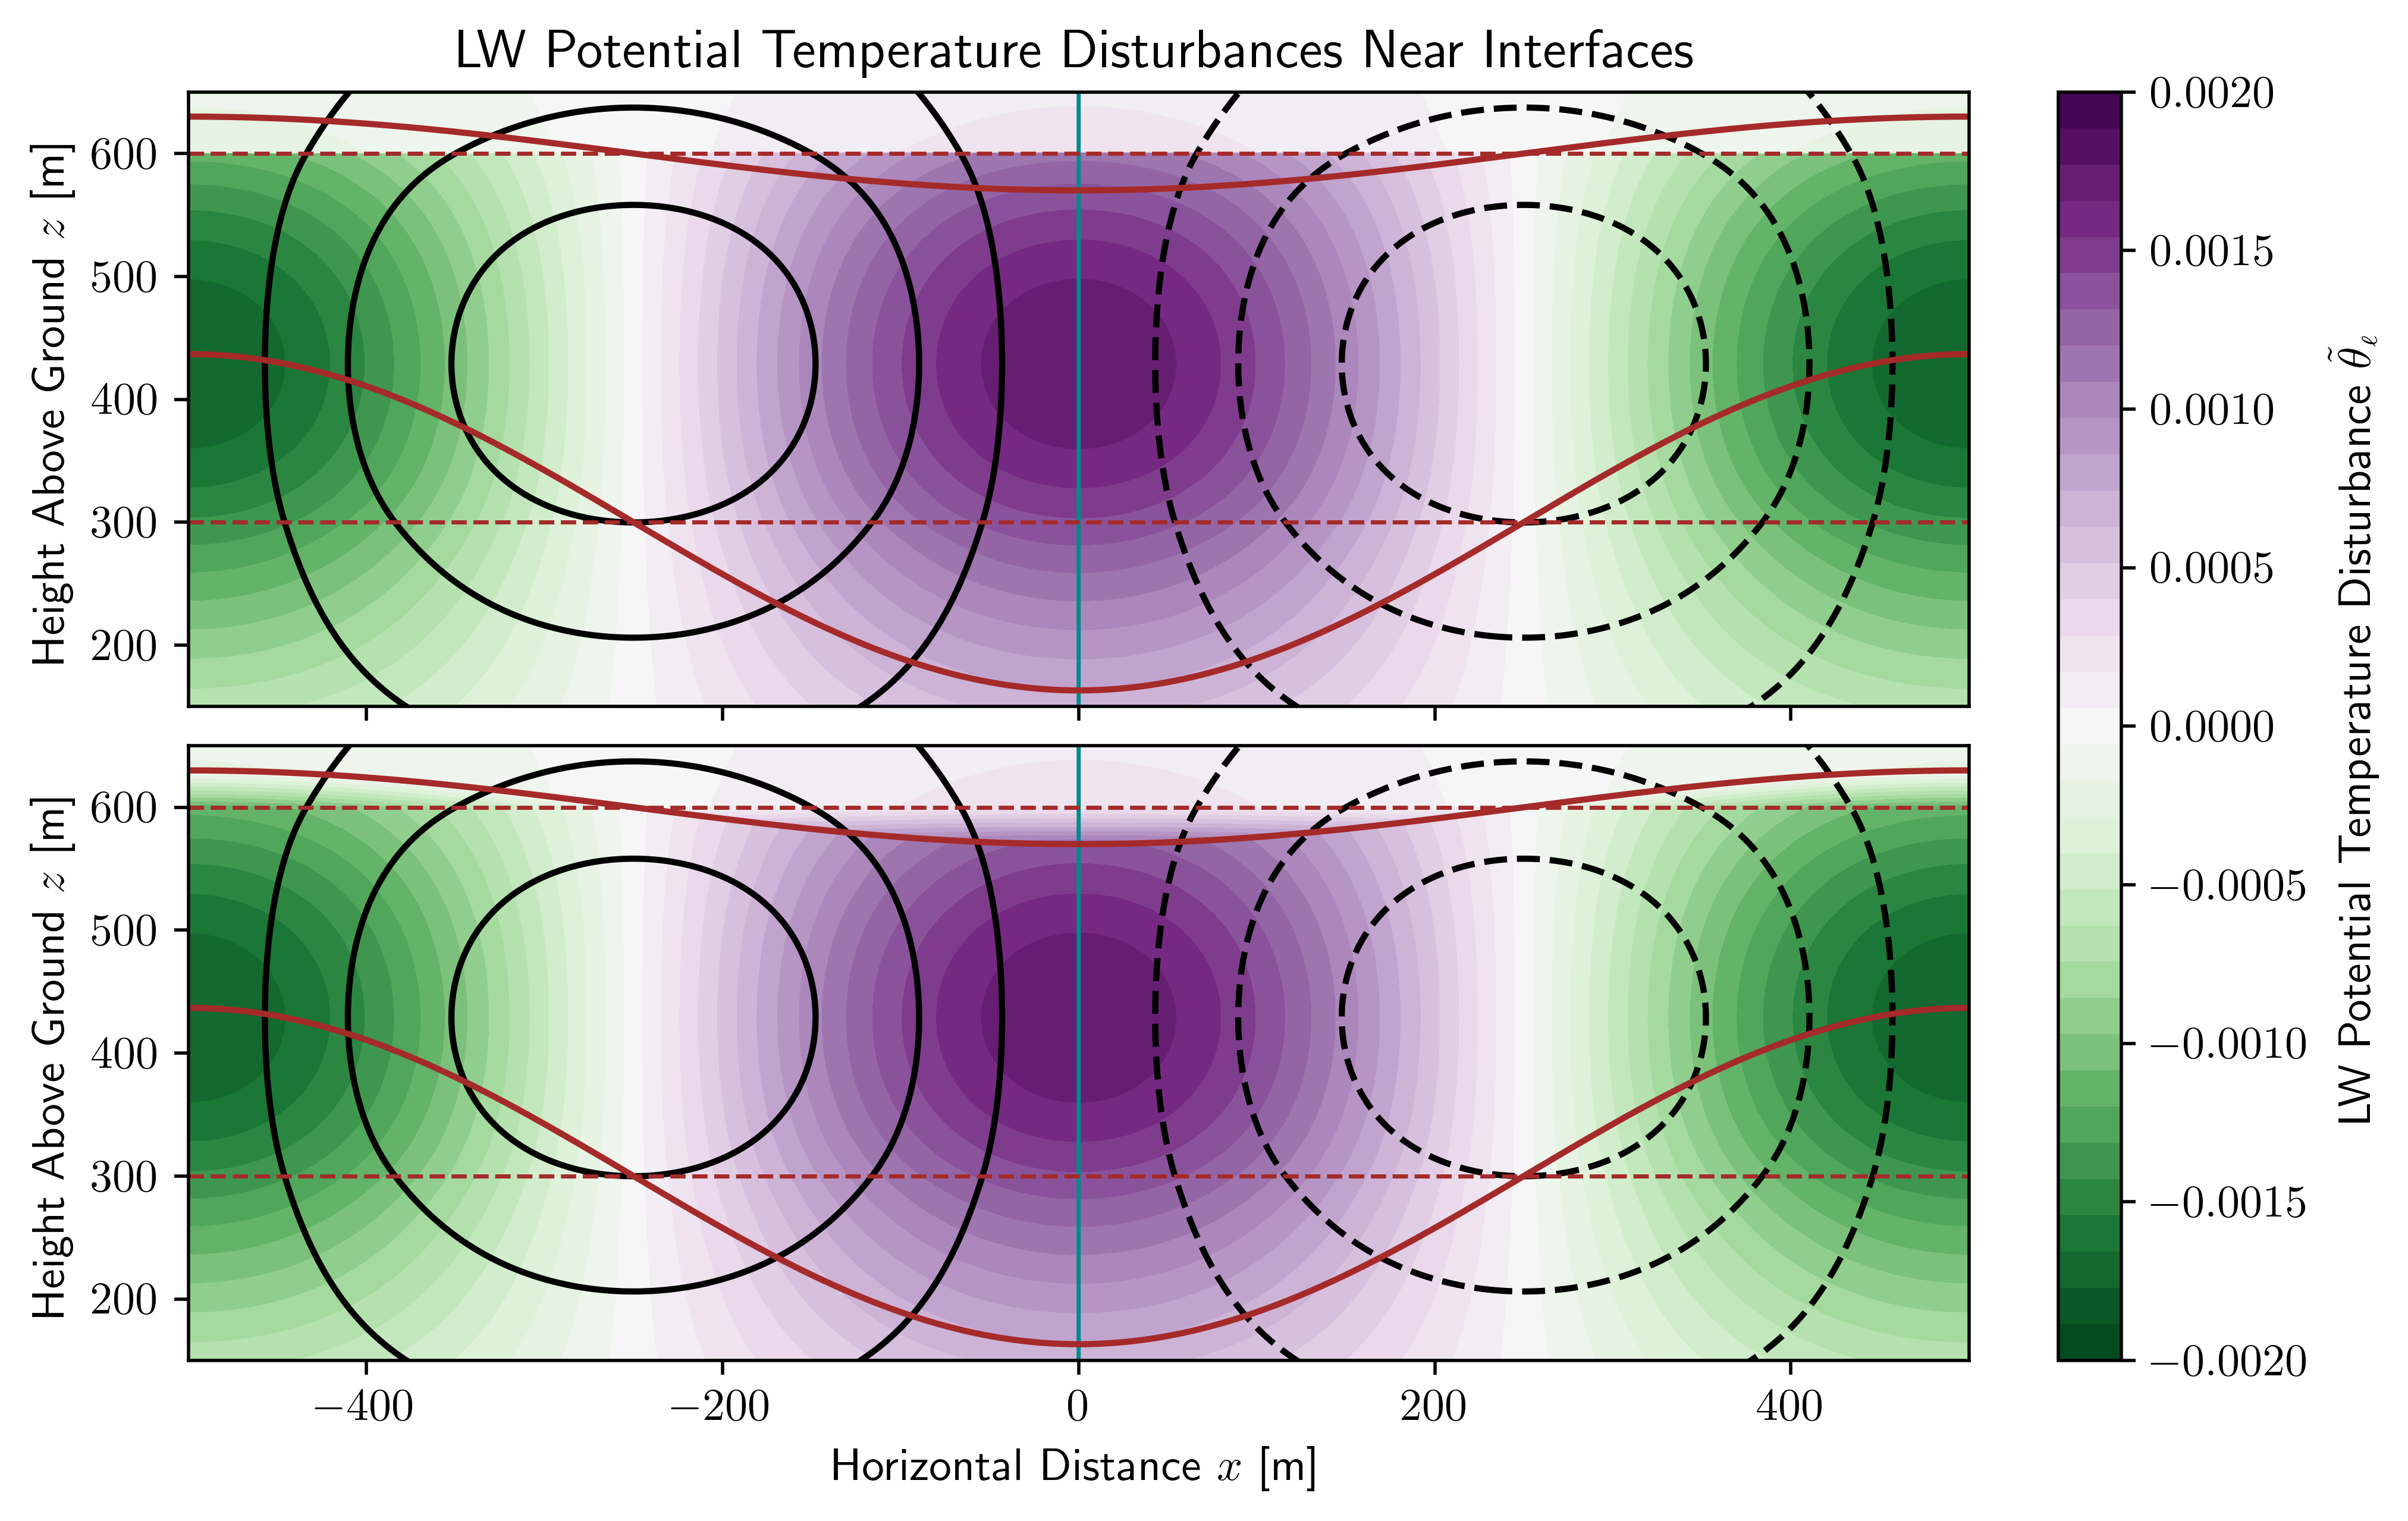

In [8]:
#Hard code parameters
k0 = 2*np.pi/1000         #wavenumber
om0 = 0.01501587419707943 #frequency
L = 2.755                 #Latent Heat Response 

#Vertical Wavenumbers
mt = k0*np.sqrt( (1 - N2t/om0**2) )
mi = k0*np.sqrt( (N2i/om0**2 - 1) )
mc = k0*np.sqrt( (1 - N2c/om0**2) )

#Continuous Fundamental Solution as in Eq (3.43)
psia = lambda z: np.where(z > Hi, np.sin(mi*Hi)*np.sinh(mt*(z - HT))/np.sinh(mt*(Hi-HT)),
                 np.where(z > Hc, np.sin(mi*z),
                                  np.sin(mi*Hc)*np.sinh(mc*z)/np.sinh(mc*Hc)))
psib = lambda z: np.where(z > Hi, np.cos(mi*Hi)*np.sinh(mt*(z - HT))/np.sinh(mt*(Hi-HT)),
                 np.where(z > Hc, np.cos(mi*z),
                                  np.cos(mi*Hc)*np.sinh(mc*z)/np.sinh(mc*Hc)))

#Matrix elements in Eq (3.44)
a = np.sin(mi*Hi)*mt/np.tanh(mt*(Hi-HT)) - mi*np.cos(mi*Hi)
b = np.cos(mi*Hi)*mt/np.tanh(mt*(Hi-HT)) + mi*np.sin(mi*Hi)
c = mi*np.cos(mi*Hc) - np.sin(mi*Hc)*mc/np.tanh(mc*Hc)
d = -mi*np.sin(mi*Hc) - np.cos(mi*Hc)*mc/np.tanh(mc*Hc)

#Verify you are using the zero eigenvector
print(f'lambda1 = {(1/2)*(np.sqrt((a - d)**2 + 4*b*c) + a + d):.1e} (This needs to be 0 (numerically) or you have the wrong eigenvector)')

#Zero eigenvector
v1 = [
    (a - d + np.sqrt((a - d)**2 + 4*b*c))/(2*c),
    1
]

#Continuous + continuous derivative normal mode
psih0 = lambda z: v1[0]*psia(z) + v1[1]*psib(z)

#theta normal mode Eq (3.46)
thh0 = lambda z: np.where(z > Hi, dlogthl_T[:,np.newaxis], dlogthl_B[:,np.newaxis],)*k0/om0*psih0(z)

#Interface displacements Eq (3.33)
Zi0 = -k0/om0*psih0(Hi)
Zc0 = -k0/om0*psih0(Hc)*(1 + L)

#Wave amplitude
#You should be able to just change factor and the contours in the plot will rescale correctly
factor = 1
Amp = -30/Zi0*factor

#2D Grid
xx = np.linspace(-500, 500, num=1001)
XX, ZZ = np.meshgrid(xx, zz[1:-1])

#axes[0] is the naive (incorrect) theta plot
#axes[1] is the delta corrected theta plot
fig, axes = plt.subplots(layout='constrained', nrows=2, sharex=True)
fig.set_size_inches(8,5)
fig.set_dpi(500)

axes[0].contourf(XX, ZZ, Amp*thh0(ZZ)*np.cos(k0*XX), levels=np.linspace(-0.002*factor, 0.002*factor, num=36), cmap='PRGn_r')

axes[0].contour(XX, ZZ, -k0*Amp*psih0(ZZ)*np.sin(k0*XX), levels=np.linspace(0,-2*Amp*k0,num=5)[1:], colors='k')
axes[0].contour(XX, ZZ, -k0*Amp*psih0(ZZ)*np.sin(k0*XX), levels=np.linspace(2*Amp*k0,0,num=5)[:-1], colors='k', linestyles='dashed')
axes[0].contour(XX, ZZ, -k0*Amp*psih0(ZZ)*np.sin(k0*XX), levels=[0], colors='darkcyan', linewidths=1)

axes[0].plot(xx, Hi + Amp*Zi0*np.cos(k0*xx), color='brown')
axes[0].plot(xx, Hc + Amp*Zc0*np.cos(k0*xx), color='brown')

axes[0].axhline(Hi, color='brown', linestyle='--', linewidth=1.)
axes[0].axhline(Hc, color='brown', linestyle='--', linewidth=1.)

axes[0].set(ylabel=r'Height Above Ground $z$ [m]', title='LW Potential Temperature Disturbances Near Interfaces')

axes[0].set(ylim=(150, 650))

#Full theta perturbation with near interface corrections
theta = np.where((ZZ >= Hi) & (ZZ >= Hi + Amp*Zi0*np.cos(k0*XX)), Amp*dlogthl_T[:,np.newaxis]*k0/om0*psih0(ZZ)*np.cos(k0*XX),
        np.where((ZZ >= Hi) & (ZZ < Hi + Amp*Zi0*np.cos(k0*XX)), np.log(thl_B/thl_T)[1:-1, np.newaxis] 
                                                              + Amp*dlogthl_B[:,np.newaxis]*k0/om0*psih0(ZZ)*np.cos(k0*XX), 
        np.where((ZZ < Hi) & (ZZ > Hi + Amp*Zi0*np.cos(k0*XX)), np.log(thl_T/thl_B)[1:-1, np.newaxis] 
                                                              + Amp*dlogthl_T[:,np.newaxis]*k0/om0*psih0(ZZ)*np.cos(k0*XX), 
                                                                Amp*dlogthl_B[:,np.newaxis]*k0/om0*psih0(ZZ)*np.cos(k0*XX))))

contf = axes[1].contourf(XX, ZZ, theta, levels=np.linspace(-0.002*factor, 0.002*factor, num=36), cmap='PRGn_r')
axes[1].contour(XX, ZZ, -k0*Amp*psih0(ZZ)*np.sin(k0*XX), levels=np.linspace(0,-2*Amp*k0,num=5)[1:], colors='k')
axes[1].contour(XX, ZZ, -k0*Amp*psih0(ZZ)*np.sin(k0*XX), levels=np.linspace(2*Amp*k0,0,num=5)[:-1], colors='k', linestyles='dashed')
axes[1].contour(XX, ZZ, -k0*Amp*psih0(ZZ)*np.sin(k0*XX), levels=[0], colors='darkcyan', linewidths=1)

axes[1].plot(xx, Hi + Amp*Zi0*np.cos(k0*xx), color='brown')
axes[1].plot(xx, Hc + Amp*Zc0*np.cos(k0*xx), color='brown')

axes[1].axhline(Hi, color='brown', linestyle='--', linewidth=1.)
axes[1].axhline(Hc, color='brown', linestyle='--', linewidth=1.)

axes[1].set(xlabel=r'Horizontal Distance $x$ [m]', ylabel=r'Height Above Ground $z$ [m]')

axes[1].set(ylim=(150, 650))

fig.colorbar(contf, ticks=np.arange(-0.002*factor, 0.0021*factor, 0.0005*factor), 
             label=r'LW Potential Temperature Disturbance $\tilde{\theta}_{\scriptscriptstyle{\ell}}$',
             ax=axes)

plt.show()